# Histopathologic

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Get the data

In [3]:
path = Path('data')

In [4]:
df = pd.read_csv(path/'histo/labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
# df['id'] = df['id'].astype(str) + '.tif'
# df.head()

In [6]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [9]:
data = ImageDataBunch.from_csv(path/'histo', folder='train', suffix='.tif', ds_tfms=tfms, size=48, test='test')

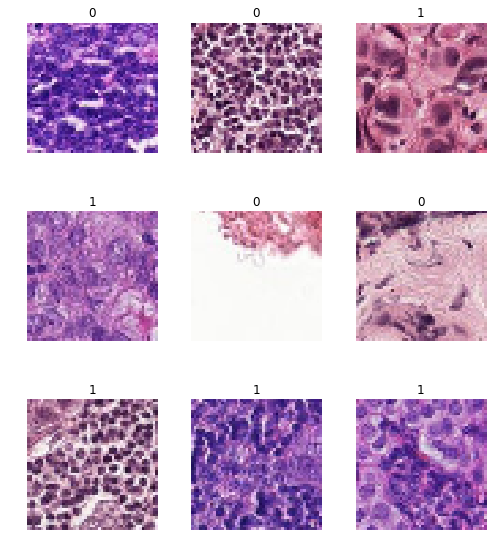

In [10]:
data.show_batch(rows=3, figsize=(7, 8))

In [11]:
len(data.train_ds), len(data.valid_ds)

(176020, 44005)

In [12]:
data.c

2

## Train model

In [13]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


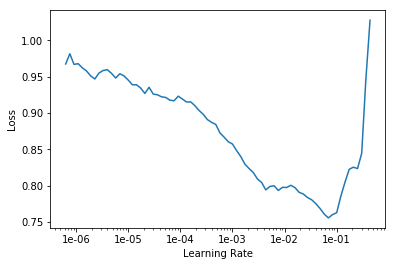

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
lr=1e-3

In [16]:
learn.fit_one_cycle(10, slice(lr))

Total time: 22:12
epoch  train_loss  valid_loss  error_rate
1      0.374261    0.335618    0.143529    (02:12)
2      0.318475    0.273961    0.112283    (02:12)
3      0.275290    0.239450    0.095376    (02:12)
4      0.252080    0.221929    0.087967    (02:12)
5      0.252527    0.210049    0.082082    (02:13)
6      0.238622    0.202751    0.079446    (02:13)
7      0.227578    0.194779    0.075855    (02:15)
8      0.225858    0.191275    0.074332    (02:12)
9      0.213123    0.190977    0.075037    (02:13)
10     0.216031    0.188815    0.073151    (02:14)



In [17]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


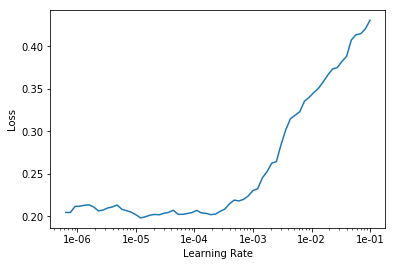

In [18]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(10, slice(1e-5, lr/5))

Total time: 27:23
epoch  train_loss  valid_loss  error_rate
1      0.204382    0.174373    0.066606    (02:43)
2      0.207919    0.173615    0.066083    (02:43)
3      0.212987    0.170916    0.064993    (02:44)
4      0.206408    0.172640    0.063016    (02:44)
5      0.188724    0.160619    0.058902    (02:44)
6      0.181941    0.149420    0.056630    (02:45)
7      0.162995    0.138564    0.052585    (02:43)
8      0.143981    0.135932    0.051312    (02:46)
9      0.146840    0.131520    0.049176    (02:43)
10     0.150375    0.129989    0.049199    (02:44)



In [22]:
learn.save('stage-one-s48')

## Increase size

In [23]:
data = ImageDataBunch.from_csv(path/'histo', folder='train', suffix='.tif', ds_tfms=tfms, size=96, test='test')

In [24]:
learn.data = data

In [25]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


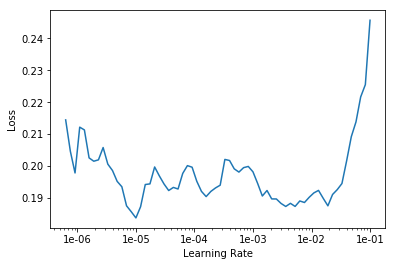

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
lr = 1e-3

In [28]:
learn.fit_one_cycle(10, slice(lr))

Total time: 33:54
epoch  train_loss  valid_loss  error_rate
1      0.116307    0.112451    0.042132    (03:24)
2      0.108174    0.089772    0.031519    (03:23)
3      0.103579    0.085219    0.030178    (03:23)
4      0.101504    0.082996    0.029292    (03:23)
5      0.091464    0.079767    0.027860    (03:23)
6      0.086192    0.076686    0.026497    (03:23)
7      0.089785    0.077287    0.026588    (03:22)
8      0.081445    0.073629    0.025702    (03:23)
9      0.080165    0.073270    0.025838    (03:23)
10     0.093385    0.072469    0.025134    (03:23)



In [29]:
learn.save('stage-two-s96-f')

In [30]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


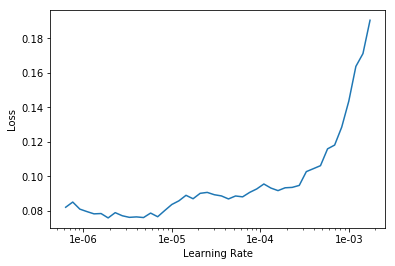

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(10, slice(1e-6, lr/5))

Total time: 45:05
epoch  train_loss  valid_loss  error_rate
1      0.083870    0.074599    0.026179    (04:30)
2      0.094263    0.072654    0.025111    (04:30)
3      0.088059    0.073433    0.024679    (04:30)
4      0.083306    0.072604    0.024974    (04:30)
5      0.070057    0.069848    0.024134    (04:30)
6      0.081158    0.065477    0.022588    (04:30)
7      0.075289    0.064841    0.022543    (04:30)
8      0.056289    0.063454    0.021089    (04:30)
9      0.056779    0.060766    0.019907    (04:30)
10     0.051353    0.061300    0.019770    (04:30)



In [33]:
learn.save('stage-two-s96-u')

## Evaluate on test set

In [35]:
len(learn.data.test_ds)

57458

In [36]:
preds = learn.TTA(ds_type=DatasetType.Test)[0]

Total time: 03:11



In [37]:
len(preds)

57458

In [38]:
# predictions = learn.get_preds(ds_type=DatasetType.Test)

In [39]:
_, predicted = torch.max(preds, 1)

In [40]:
def get_row(idx):
    pred = predicted[idx].item()
    
    image_path = learn.data.test_ds.x.items[idx]
    image_name = re.search(r'([^/]+)$', f'{image_path}')[0].replace('.tif', '')
    
    return image_name, pred

In [42]:
df = pd.DataFrame(columns=['id', 'label'])
for idx in range(len(preds)):
    if idx % 5000 == 0:
        print(f"Completed: {idx}")
        
    image_name, label = get_row(idx)
    df.loc[idx] = [image_name, label]

Completed: 0
Completed: 5000
Completed: 10000
Completed: 15000
Completed: 20000
Completed: 25000
Completed: 30000
Completed: 35000
Completed: 40000
Completed: 45000
Completed: 50000
Completed: 55000


In [43]:
df.head()

,id,label
0,c0b24bad7fdeca3d8735e7850e024bf875787f83,1
1,269d2cfba4e896769ab014b2ff1febed375d0d4b,0
2,4c28a41001aac38890ca3231c83287cb5dafc315,0
3,7f8ee7d399bf9136e8ef5feba087c2072486ca4b,1
4,f12574827d49289645eb1d89c3a2afd12c516bca,0


In [44]:
df.to_csv('sub.csv', index=False)